# A/B-тесты

## Задача 1. A/A-тест.

Перед проведением A/B- теста есть необходимость для начала провести A/A-тест, который покажет, работает ли корректно наша система сплитования, а также что ключевая метрика не отличается между группами не только в конкретно нашем А/А-тесте, но и в общем.  Идеально было бы провести бесчисленное количество А/А-тестов и узнать, как часто мы получаем статистически значимые различия только из-за случайных факторов.

На практике провести бесконечные тесты невозможно, поэтому мы будем многократно извлекать подгруппы из данных нашего А/А-теста и проверять их с помощью t-теста. Нам нужно смоделировать проведение 10000 А/А-тестов на данных с '2023-09-21' по '2023-09-27'. На каждой итерации извлекаем без повторений подгруппы по 500 юзеров из 2 и 3 экспериментальных групп, проводим t-тест и сохраняем полученные p-values.

После этого:

1. Строим гистограмму, показывающую распределение 10000 p-values..

2. Рассчитываем процент p-values, меньших или равных 0.05.

3. Делаем вывод о корректности работы системы сплитования на основе проведенного А/А-теста.

In [37]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import matplotlib as mpl
from scipy import stats

In [30]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20231020',
'user':'student',
'password':'dpo_python_2020'
}

In [31]:
query = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-09-21' and '2023-09-27'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""


In [66]:
df = ph.read_clickhouse(query, connection=connection)

In [34]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,38,248,0.153226
1,3,10326,24,132,0.181818
2,3,123580,25,122,0.204918
3,2,131473,19,98,0.193878
4,2,23985,12,44,0.272727


In [67]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8362,8362,8362,8362
3,8425,8425,8425,8425


Количество пользователей в группах примерно одинаковое

Визуализируем ctr значения наших групп при помощи гистограммы:

In [39]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

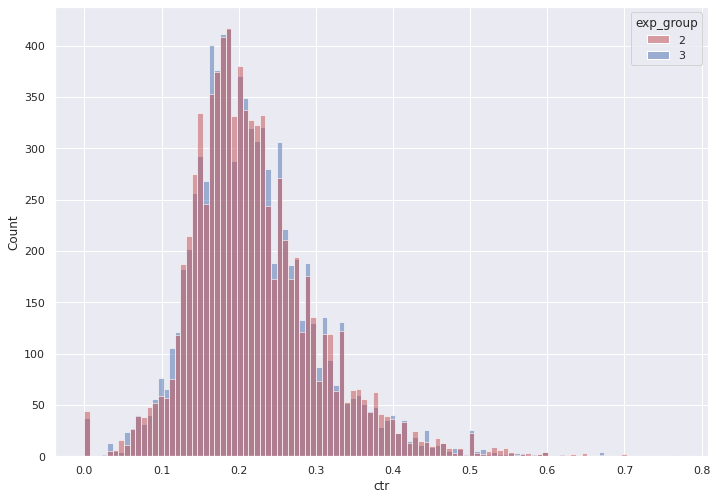

In [40]:
groups = sns.histplot(data = df,
                     x = 'ctr',
                     hue = 'exp_group',
                     palette = ['r','b'],
                     alpha = 0.5)

Проанализированные две группы пользователей (контрольная и тестовая) очень похожи. Показатели ctr у групп практически не отличаются. 

Распределение одномодальное, похожее на нормальное с немного вытянутым хвостом в правой стороне, выбросов практически нет.

Чтобы удостовериться в наших выводах, проведем A/A-тест.

Проведем t-тест Стьюдента:

$$
\text{Нулевая гипотеза } H_0 : \mu_1 = \mu_2
$$

$$
\text{Альтернативная гипотеза } H_1 : \mu_1 \neq \mu_2
$$

In [41]:
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.6617303509169986, pvalue=0.508153138292614)

Значение p value большое ~ 0.508, принимается нулевая гипотеза о равенстве средних. Из этого можно сделать вывод, что отличие не является статистически значимым и отличия между группами, вероятно, отсутствует.

Проведем U test Манна-Уитни:

$$
\text{Нулевая гипотеза } H_0: P(X>Y) = P(Y>X)
$$

$$
\text{Альтернативная гипотеза } H_1: P(X>Y) \neq P(Y>X)
$$

In [45]:
stats.mannwhitneyu(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr)

MannwhitneyuResult(statistic=35290681.5, pvalue=0.8340910379715747)

Значение p value большое ~ 0.834, принимается нулевая гипотеза. Из этого можно сделать вывод о том, что нет статистически значимых различий между двумя выборками. 

Проведем симуляцию 10000 A/A-тестов, сформировав на каждой итерации подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальных групп:

In [54]:
res = []
for i in range(10000):
    second = df[df.exp_group == 2].ctr.sample(500, replace = False) 
    third = df[df.exp_group == 3].ctr.sample(500, replace = False) 
    res.append(stats.ttest_ind(second, third, equal_var=False)[1])

<Axes: ylabel='Count'>

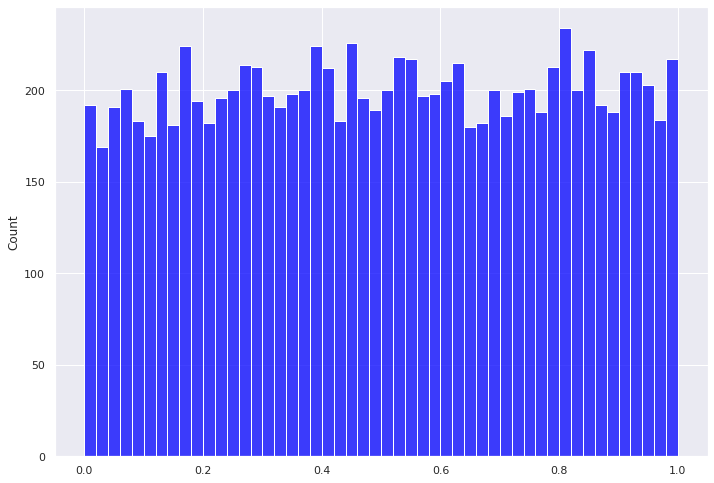

In [63]:
sns.histplot(res, color='blue', bins=50)

Из построенной гистограммы видно, что p-value распределены довольно равномерно

Теперь посчитаем какой процент p values оказался меньше либо равен 0.05:

In [71]:
n = sum(p <= 0.05 for p in res)
n_perc = (n / len(res)) * 100
print(f'Процент p values, который меньше или равен 0.05: {n_perc}%')

Процент p values, который меньше или равен 0.05: 4.67%


**Вывод по проведенному А/А-тесту**

Результаты A/A-теста показали, что процент p values составил 4.67%. Это означает, что в 4.67% случаев наши А/А-тесты демонстрировали статистически значимые различия между экспериментальными группами при уровне значимости alpha = 0.05 (то есть ниже уровня значимости в 5%). Таким образом, можно с уверенностью сказать, что случайная подвыборка из 500 пользователей с вероятностью 95.33% будет нести в себе признаки генеральной совокупности размером в примерно 8400 пользователей. 

Эти результаты подтверждают надежность и корректность нашей системы сплитования. Ключевая метрика (в данном случае ctr) не демонстрирует статистически значимых различий между группами не только в данном конкретном A/A-тесте, но и в целом. Успех A/A-теста сообщает нам о готовности к проведению A/B-теста.